In [1]:
pip install tensorflow opencv-python matplotlib


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


35363/35363 [==============================] - 0s 0us/step
Predicted: [('n02106030', 'collie', 0.54888034), ('n02105855', 'Shetland_sheepdog', 0.16636965), ('n02356798', 'fox_squirrel', 0.019600106)]


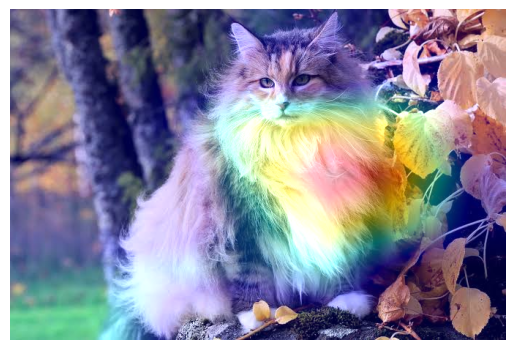

In [3]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50, resnet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 모델 로드
model = ResNet50(weights='imagenet')

# 이미지를 로드하고 전처리
img_path = '/content/gdrive/My Drive/images.jpeg'
img = image.load_img(img_path, target_size=(224, 224))
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

# 예측 및 예측된 클래스 확인
preds = model.predict(x)
print('Predicted:', decode_predictions(preds, top=3)[0])

# Grad-CAM 구현
def get_gradcam_heatmap(model, img_array, last_conv_layer_name, pred_index=None):
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 마지막 합성곱 층 이름
last_conv_layer_name = 'conv5_block3_out'

# Grad-CAM heatmap 생성
heatmap = get_gradcam_heatmap(model, x, last_conv_layer_name)

# 원본 이미지 위에 heatmap을 겹쳐서 표시
def superimpose_heatmap(img_path, heatmap, alpha=0.4):
    img = cv2.imread(img_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = heatmap * alpha + img
    superimposed_img = np.clip(superimposed_img, 0, 255).astype(np.uint8)
    return superimposed_img

superimposed_img = superimpose_heatmap(img_path, heatmap)

# 결과 표시
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.show()
